### Profiling R following Zheng *et al.*, Nat. Comm. (2017)

This has been copied line by line from the *Cell Ranger* R scripts of Zheng *et al.*, Nat. Comm. (2017) available from https://github.com/10XGenomics/single-cell-3prime-paper with profiling information.

The pbmc64k data is freely available from the 10x homepage or from the previous GitHub link.

In [12]:
library(Matrix)
library(ggplot2)
library(Rtsne)
library(svd)
library(dplyr)
library(plyr)
library(data.table)
library(pryr)

Cell Ranger is neither packaged nor versioned, we are running the state commited here [265433](https://github.com/10XGenomics/single-cell-3prime-paper/commit/265433ebf858c7fdcab759ca9f36b5e0241ceece), downloaded on May 1st, 2017.

The initial use of memory is.

In [2]:
mem_used(); previous_mem <- mem_used()

1.02 GB

In [3]:
use_first_n_samples = 500

Set the file paths.

In [4]:
DATA_DIR <- "./data/"
PROG_DIR <- "./"     # SPECIFY HERE
RES_DIR  <- "./results_cellranger/"      # SPECIFY HERE
source(file.path(PROG_DIR,'zheng17_cellranger_utils.R'))

Load the data.

In [5]:
previous_time <- proc.time()[3]
pbmc_68k <- readRDS(file.path(DATA_DIR,'pbmc68k_data.rds'))
all_data <- pbmc_68k$all_data
mem_used(); mem_used() - previous_mem; previous_mem <- mem_used()
proc.time()[3] - previous_time

1.63 GB

609 MB

elapsed 
  2.955

Reduce the number of samples for scaling information.

In [6]:
if (use_first_n_samples != 0) {
   m<-all_data[[1]]$hg19$mat[1:use_first_n_samples,]
} else { 
   m<-all_data[[1]]$hg19$mat
}

Per-cell normalize the data matrix $X$ and identify highly-variable genes. 

In [7]:
previous_time <- proc.time()[3]
l<-.normalize_by_umi(m)
m_n<-l$m
df<-.get_variable_gene(m_n)
disp_cut_off<-sort(df$dispersion_norm,decreasing=T)[1000]
df$used<-df$dispersion_norm >= disp_cut_off
cat('dispersion cutoff:', disp_cut_off)
mem_used(); mem_used() - previous_mem; previous_mem <- mem_used()
proc.time()[3] - previous_time

dispersion cutoff: 2.872114

1.64 GB

9.33 MB

elapsed 
  1.756

Plot the dispersion relation.

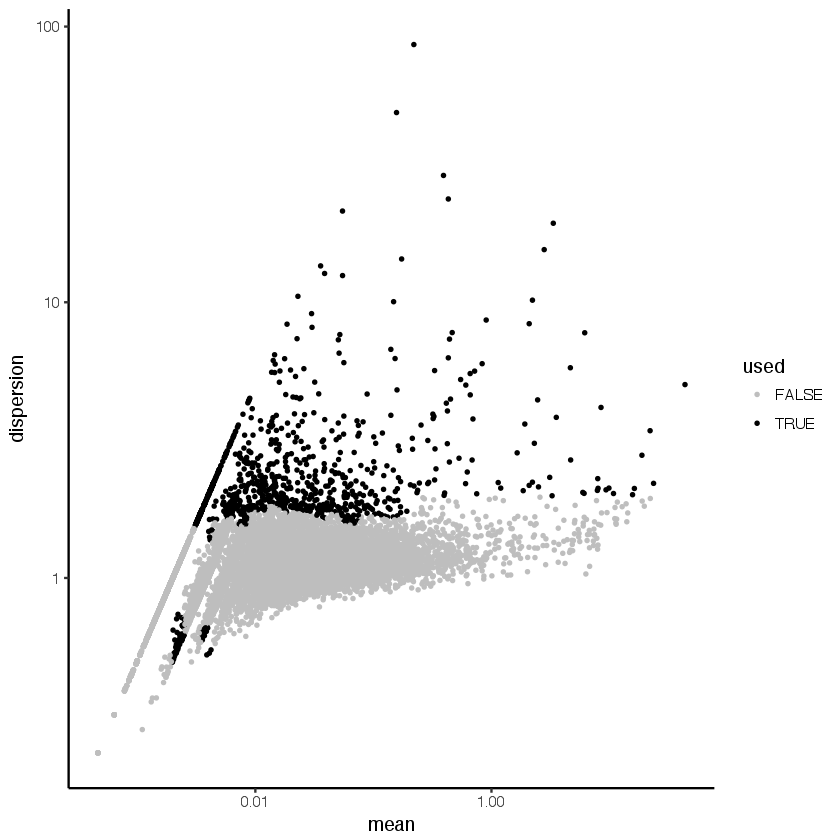

In [8]:
ggplot(df,aes(mean,dispersion,col=used))+geom_point(size=0.5)+scale_x_log10()+scale_y_log10()+
  scale_color_manual(values=c("grey","black"))+theme_classic()

Compute PCA.

In [9]:
previous_time <- proc.time()[3]
# --------------------------------------------
# use top 1000 variable genes for PCA 
# --------------------------------------------
set.seed(0)
m_n_1000<-m_n[,head(order(-df$dispersion_norm),1000)]
pca_n_1000<-.do_propack(m_n_1000,50)
mem_used(); mem_used() - previous_mem; previous_mem <- mem_used()
proc.time()[3] - previous_time

1.65 GB

8.46 MB

elapsed 
  1.435

Compute tSNE.

In [10]:
previous_time <- proc.time()[3]
# --------------------------------------------
# generate 2-D tSNE embedding
# this step may take a long time
# --------------------------------------------
tsne_n_1000<-Rtsne(pca_n_1000$pca,pca=F)
mem_used(); mem_used() - previous_mem; previous_mem <- mem_used()
proc.time()[3] - previous_time

1.65 GB

58.9 kB

elapsed 
  5.806

Load bulk expression to define cell types.

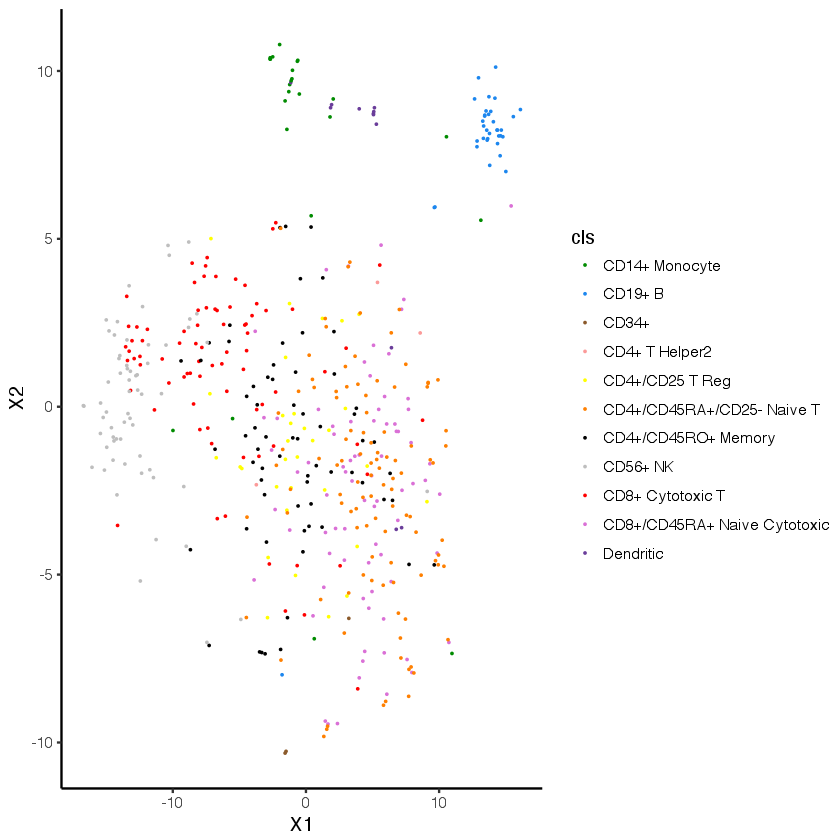

In [11]:
tdf_n_1000<-data.frame(tsne_n_1000$Y)
pure_11 <- readRDS(file.path(DATA_DIR,'all_pure_select_11types.rds'))
purified_ref_11 <- load_purified_pbmc_types(pure_11,pbmc_68k$ens_genes)
# ---------------------------------------------------------------------------------------------------------------------------
# assign IDs by comparing the transcriptome profile of each cell to the reference profile from purified PBMC populations
# this produces Fig. 3j in the manuscript
# ---------------------------------------------------------------------------------------------------------------------------
m_filt<-m_n_1000
use_genes_n<-order(-df$dispersion_norm)
use_genes_n_id<-all_data[[1]]$hg19$gene_symbols[l$use_genes][order(-df$dispersion_norm)]
use_genes_n_ens<-all_data[[1]]$hg19$genes[l$use_genes][order(-df$dispersion_norm)]
z_1000_11<-.compare_by_cor(m_filt,use_genes_n_ens[1:1000],purified_ref_11) 
# reassign IDs, as there're some overlaps in the purified pbmc populations
test<-.reassign_pbmc_11(z_1000_11)
cls_id<-factor(colnames(z_1000_11)[test])
tdf_n_1000$cls_id<-cls_id
# adjust ordering of cells for plotting aesthetics
tdf_mod <- tdf_n_1000[tdf_n_1000$cls_id!='CD4+/CD45RA+/CD25- Naive T',]
tdf_mod <- rbind(tdf_mod,tdf_n_1000[tdf_n_1000$cls_id=='CD4+/CD45RA+/CD25- Naive T',])
tdf_mod_2 <- tdf_mod[tdf_mod$cls_id!='CD56+ NK',]
tdf_mod_2 <- rbind(tdf_mod_2,tdf_mod[tdf_mod$cls_id=='CD56+ NK',])
ggplot(tdf_mod_2,aes(X1,X2,col=cls_id))+geom_point(size=0,alpha=1)+theme_classic()+.set_pbmc_color_11()